## Import Statements

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from os.path import join
from src.training import HyperparameterSearch
from src.data_loading import prepare_ground_truth_data
from sklearn.metrics import confusion_matrix


## Training Approach

Training the data on a five-label classification problem for all heart issues seems unfeasible. Thus, we train the data on a binary classification of being healthy or pathological. We define pathological as every diagnostic superclass that is not "NORM."

To this end, we train a basic CNN model on the task of binary classification.

In [2]:
data_path = "../data/processed"
X = np.load(join(data_path, "X.npy"))
Y = pd.read_csv(join(data_path, "y.csv"))
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(json.loads)
Y = prepare_ground_truth_data(Y)

## Investigate Data Distribution of Labels

We first investigate the data distribution of the ground truth labels

/var/folders/f3/sjrhhs9n24n82n8gvmbk37y00000gn/T/ipykernel_1879/2766318168.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


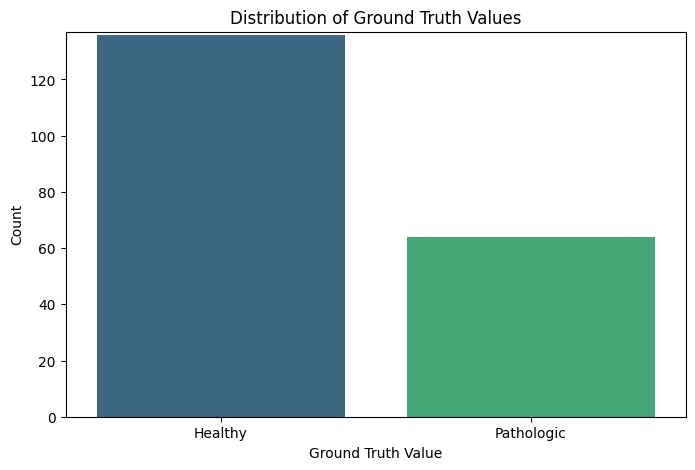

In [3]:
class_counts = Y['ground_truth'].apply(lambda x: x[0]).value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Ground Truth Values')
plt.xlabel('Ground Truth Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Healthy', 'Pathologic'])
plt.ylim(0, class_counts.max() + 1)  # Add some space above bars for aesthetics
plt.show()

## Hyperparameter Optimization

We conduct a hyperparameter optimization using a Leave-K-Patients-Out Cross-Validation and tune the model for a set of hyperparameters. For the test set, we utilize the fixed stratified fold as recommended by Physionet. For the training data, we perform the LKPO CV in the inner loop. Given the larger dataset and the limited training size, we reduce the steps of model trainings to n=10.

In [4]:
test_fold = 10
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)]
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold]

print(os.getcwd())
model_path = "../param_search"

WINDOW_SIZE = 100
STRIDE = 100
N_EPOCHS = 1

opt_search = HyperparameterSearch(X_train, y_train, X_test, y_test, model_path, WINDOW_SIZE, STRIDE, N_EPOCHS)
opt_search.perform_search(n_calls=10)

/Users/justinalbert/Development/Idoven-DS-Machine-Learning/notebooks
Training with params: [14, 0.00023273922280628724, 0.6118764001091077, (32, 64, 128)]
Training with params: [12, 0.00015847101210439096, 0.4836995567863469, (16, 32, 64)]
Training with params: [9, 0.0020034427927560746, 0.3225646316108401, (32, 64, 128)]
Training with params: [16, 0.00010035927878780911, 0.6968846237164871, (32, 64, 128)]
Training with params: [13, 0.0001033076804324041, 0.3092249700165663, (32, 64, 128)]
Training with params: [11, 0.00012397420340784146, 0.6895022075365838, (16, 32, 64)]
Training with params: [9, 0.0017249321573178998, 0.45298479650686513, (32, 64, 128)]
Training with params: [12, 0.005246634533625288, 0.5721230154351119, (16, 32, 64)]
Training with params: [8, 0.0076630826802558585, 0.5253152871382157, (16, 32, 64)]
Training with params: [8, 0.0002895927274708839, 0.3964101864104047, (32, 64, 128)]
Best hyperparameters found: [9, 0.0017249321573178998, 0.45298479650686513, (32, 64, 

## Model evaluation

After performing the hyperparameter optimization, we investigate the model performance on the pre-defined test set. To this end, we load the stored best hyperparameter combination and retrain the model on the entire training data.

[9, 0.0017249321573178998, 0.45298479650686513, (32, 64, 128)]
Train loss: 0.6015875449263921


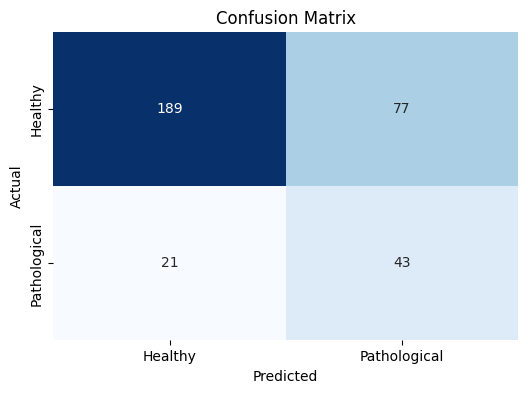

In [10]:
with open(join(model_path, "best_params.pkl"), 'rb') as file:
    loaded_results = pickle.load(file)

print(loaded_results)
predictions, labels = opt_search.evaluate_model(loaded_results)

# Calculate confusion matrix
# Manually calculate confusion matrix values
TP = sum((l == 1 and p == 1) for l, p in zip(labels, predictions))
TN = sum((l == 0 and p == 0) for l, p in zip(labels, predictions))
FP = sum((l == 0 and p == 1) for l, p in zip(labels, predictions))
FN = sum((l == 1 and p == 0) for l, p in zip(labels, predictions))

# Create confusion matrix as a 2x2 list, usually one would use the sklearn confusion matrix function. Due to numpy and pytorch compability issues right now, I'm calculating it manually
conf_matrix = [[TN, FP], [FN, TP]]

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Pathological'], yticklabels=['Healthy', 'Pathological'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Next Actions

We have initially explored this dataset and found that 

- Test
- OK